In [1]:
import warnings
warnings.filterwarnings('ignore')
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from math import sqrt
import statistics
import keras
from numpy import array
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from numpy import array
from influxdb import *
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [2]:
df = pd.read_excel(r'C:\Users\u22v09\Desktop\Energy2020-05-29to2020-09-17.xlsx')
#df = df.rename(columns = {'Unnamed: 0':'time'}).set_index('time')
# df = df[['time','EM4']]
df=df.set_index('time')
df.index.freq = 'H'
df[df['EM4'] < 0] = 0
df1 = df.copy()


# Data Processing: 24 input and 4 ouput points

In [3]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
raw_seq = list(df1['EM4'].values)
n_steps_in, n_steps_out = 24,4
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

In [4]:
t =[]
x =[]
for i in range(len(X)):
    t.append(X[i])
    x.append(y[i])
inp = pd.DataFrame(t)
out = pd.DataFrame(x)
out = out.rename(columns= {0:'out1',1:'out2',2:'out3',3:'out4'})

In [5]:
df2 = inp.merge(out, left_index = True, right_index = True)

In [32]:
df2

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,out1,out2,out3,out4
0,13.0,24.0,24.0,24.0,24.0,24.0,24.0,23.0,24.0,23.0,...,249.0,235.0,226.0,231.0,236.0,85.0,25.0,25.0,25.0,24.0
1,24.0,24.0,24.0,24.0,24.0,24.0,23.0,24.0,23.0,24.0,...,235.0,226.0,231.0,236.0,85.0,25.0,25.0,25.0,24.0,24.0
2,24.0,24.0,24.0,24.0,24.0,23.0,24.0,23.0,24.0,115.0,...,226.0,231.0,236.0,85.0,25.0,25.0,25.0,24.0,24.0,25.0
3,24.0,24.0,24.0,24.0,23.0,24.0,23.0,24.0,115.0,227.0,...,231.0,236.0,85.0,25.0,25.0,25.0,24.0,24.0,25.0,24.0
4,24.0,24.0,24.0,23.0,24.0,23.0,24.0,115.0,227.0,143.0,...,236.0,85.0,25.0,25.0,25.0,24.0,24.0,25.0,24.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2628,90.0,127.0,144.0,142.0,148.0,136.0,118.0,148.0,154.0,158.0,...,63.0,84.0,88.0,97.0,98.0,82.0,7.0,43.0,117.0,119.0
2629,127.0,144.0,142.0,148.0,136.0,118.0,148.0,154.0,158.0,167.0,...,84.0,88.0,97.0,98.0,82.0,7.0,43.0,117.0,119.0,139.0
2630,144.0,142.0,148.0,136.0,118.0,148.0,154.0,158.0,167.0,150.0,...,88.0,97.0,98.0,82.0,7.0,43.0,117.0,119.0,139.0,143.0
2631,142.0,148.0,136.0,118.0,148.0,154.0,158.0,167.0,150.0,133.0,...,97.0,98.0,82.0,7.0,43.0,117.0,119.0,139.0,143.0,133.0


In [6]:
X = df2.drop(['out1','out2','out3','out4'], axis = 1).values
y = df2[['out1','out2','out3','out4']].values

In [41]:
len(df2)

2633

# Train  & Test Split

In [51]:
tr = int(round(len(df2)*0.7, 0))
train=df2[:tr]
test=df2[tr:]

In [52]:
X_train = train.drop(['out1','out2','out3','out4'], axis = 1).values
y_train = train[['out1','out2','out3','out4']].values
X_test = test.drop(['out1','out2','out3','out4'], axis = 1).values
y_test = test[['out1','out2','out3','out4']].values

In [53]:
X_train.shape

(1843, 24)

In [54]:
X_test.shape

(790, 24)

# Performance on Train

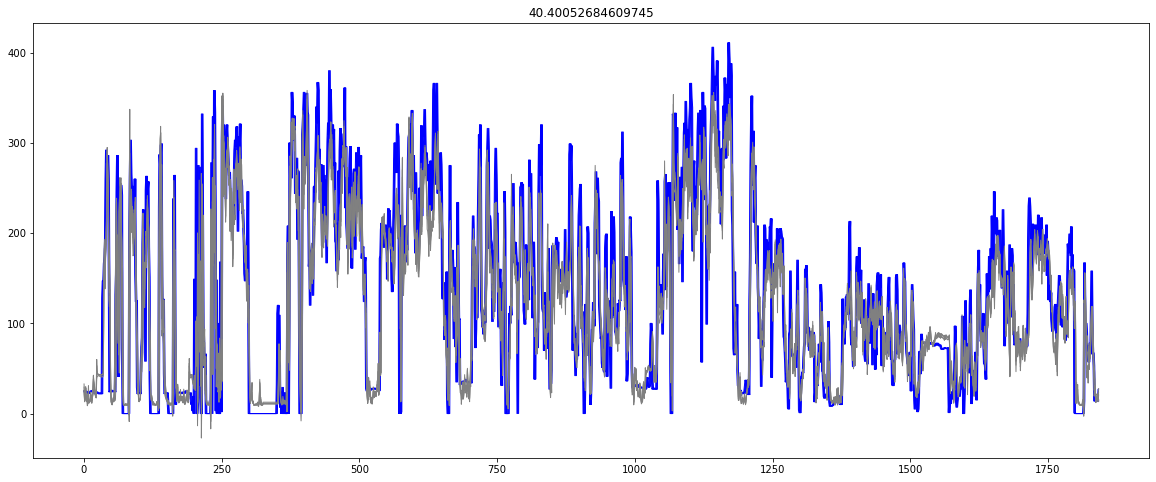

In [55]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim = n_steps_in))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))
# model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=500, verbose=0)

#model.save("MLP_model.h5")

yhat_train = model.predict(X_train, verbose=0)
rmse = sqrt(mean_squared_error(yhat_train,y_train))

plt.figure(figsize=(20,8))
plt.plot(y_train, label='True', lw = 1, color = 'blue')
plt.plot(yhat_train, label='predict', lw = 1, color = 'grey')
plt.title(rmse)
plt.show()

In [56]:
#model.save("MLP_model.h5")

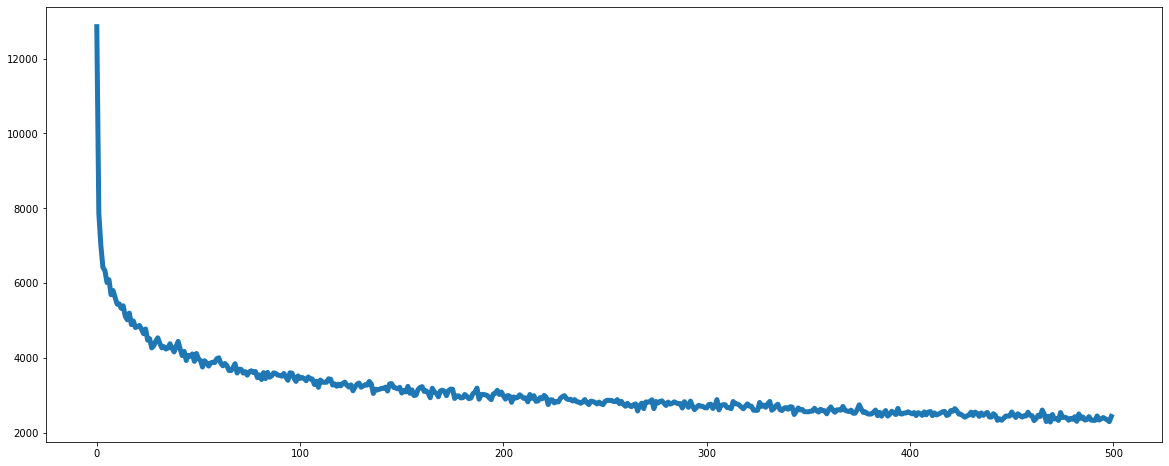

In [57]:
loss = model.history.history['loss']
epochs = range(len(loss))
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['lines.linewidth'] = 5
plt.plot(epochs, loss)

In [58]:
yhat_test = model.predict(X_test, verbose=0)
x = pd.DataFrame(yhat_test)
x = x.unstack().reset_index().drop(['level_0','level_1'],axis=1).rename(columns={0:'Predicted'})
y = pd.DataFrame(y_test)
y = y.unstack().reset_index().drop(['level_0','level_1'],axis=1).rename(columns={0:'Test'}) 
df_out = x.merge(y,left_index=True, right_index= True)
df_out.head()

,Predicted,Test
0,15.582285,14.0
1,17.698757,27.0
2,11.540598,14.0
3,11.848669,16.0
4,58.483585,16.0


In [59]:
round(rmse,2)

40.4

# Performance on Test

In [60]:
yhat_test = model.predict(X_test, verbose=0)
x = pd.DataFrame(yhat_test)
x = x.unstack().reset_index().drop(['level_0','level_1'],axis=1).rename(columns={0:'Predicted'})
y = pd.DataFrame(y_test)
y = y.unstack().reset_index().drop(['level_0','level_1'],axis=1).rename(columns={0:'Test'}) 
df_out = x.merge(y,left_index=True, right_index= True)
df_out

,Predicted,Test
0,15.582285,14.0
1,17.698757,27.0
2,11.540598,14.0
3,11.848669,16.0
4,58.483585,16.0
...,...,...
3155,89.242699,119.0
3156,14.633778,139.0
3157,44.415337,143.0
3158,124.366920,133.0


In [61]:
round(sqrt(mean_squared_error(df_out,df_out)),2)

0.0

In [62]:
rmse_test = round(sqrt(mean_squared_error(yhat_test,y_test)),2)
rmse_test

45.27

In [63]:
ll=[]
for i in range(0,len(y_test)):
    rmse_t = round(sqrt(mean_squared_error(yhat_test[i],y_test[i])),2)
    ll.append(rmse_t)

In [64]:
statistics.mean(ll)

36.77316455696202

In [65]:
y_test

array([[ 14.,  27.,  14.,  16.],
       [ 27.,  14.,  16.,  16.],
       [ 14.,  16.,  16.,   9.],
       ...,
       [117., 119., 139., 143.],
       [119., 139., 143., 133.],
       [139., 143., 133., 179.]])

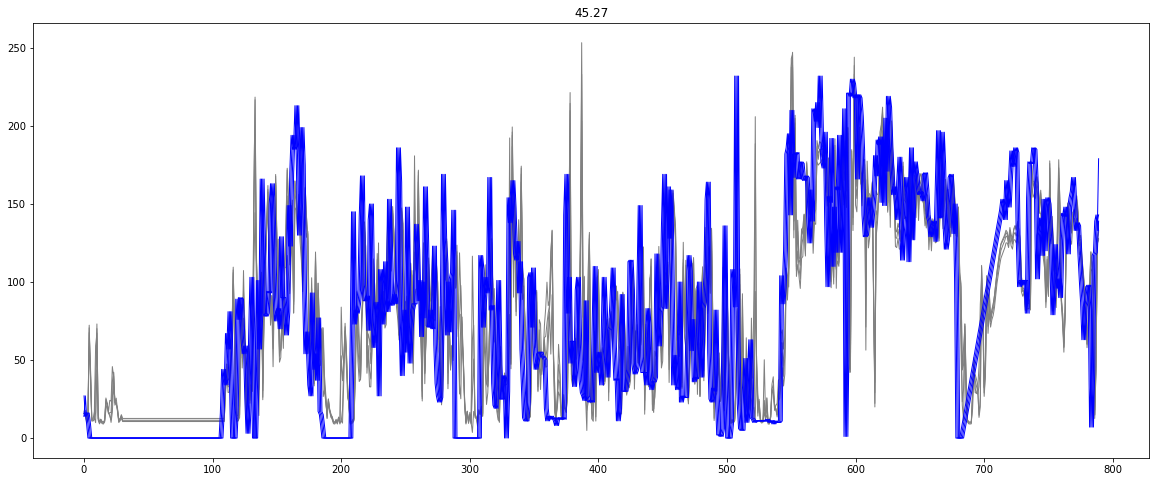

In [66]:
plt.figure(figsize=(20,8))
plt.plot(yhat_test, label='Predicted', lw = 1, color = 'grey')
plt.plot(y_test, label='Test', lw = 1, color = 'blue')
plt.title(rmse_test)
plt.show()